# Combined model of RV and H$\alpha$

## Overall model is quasiperiodic in RV, quasiperiodic + extra squared exponential in H$\alpha$

<ul>
    <li>When doing a GP model of H$\alpha$ alone, I found that adding a long-term signal drift using an extra squared exponential kernel improved the fit. This may make sense because there could be a long-term activity cycle that is only partially covered by this dataset.</li>
    <li>I didn't find the extra signal drift as important for the RV data; perhaps the long-term cycle manifests less in RV than in H$\alpha$?</li>
    <li>Period and decorrelation time are shared between two quasi-periodic kernels; amplitude and roughness can be different.</li>
</ul>

### 1. Get data:

In [947]:
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
% matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

### 2. Plot RV, H$\alpha$, and their periodograms:

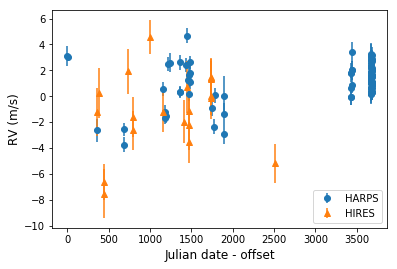

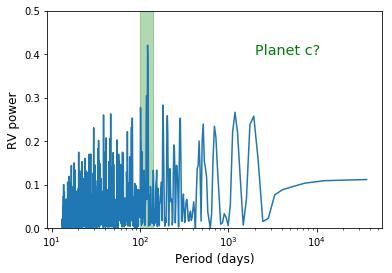

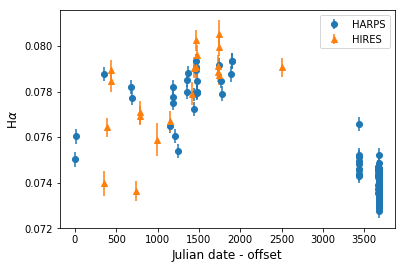

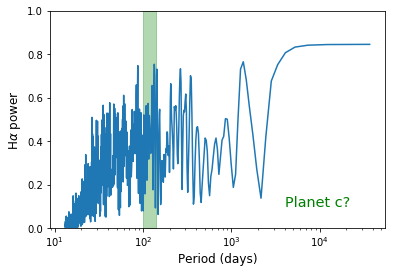

In [948]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

### 3. Set up the Gaussian processes with shared period and decorrelation time; find best-fit parameters:

In [949]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''
# Quasi-periodic kernels
constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_ha = 4.0e-5
gamma_guess_RV = 3. # Amplitudes of periodic part of kernels
gamma_guess_ha = 12.
metric_guess = 50000. # Decorrelation timescale SQUARED (days)
period_guess = 110. # Best-fit period from GP model of RV alone
# Long-term squared exponential kernel for signal drift in Halpha
lt_constant_ha = 0.0003
lt_metric_ha = 1500000.

'''Can experiment with the hyperparameter initial guesses here
#constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_ha = 4.0e-5
gamma_guess_RV = 3. # Amplitudes of periodic part of kernels
gamma_guess_ha = 12.
metric_guess = 50000. # Decorrelation timescale SQUARED (days)
period_guess = 110. # Best-fit period from GP model of RV alone
# Long-term squared exponential kernel for signal drift in Halpha
lt_constant_ha = 0.0003
lt_metric_ha = 1500000.
'''

# Create the kernels
kexp2_RV = constant_guess_RV * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_ha = constant_guess_ha * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_RV_lt = constant_guess_RV * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_ha_lt = constant_guess_ha * kernels.ExpSquaredKernel(metric=metric_guess)

kper_RV = kernels.ExpSine2Kernel(gamma=gamma_guess_RV, log_period=np.log(period_guess))
kper_ha = kernels.ExpSine2Kernel(gamma=gamma_guess_ha, log_period=np.log(period_guess))
kper_RV_lt = kernels.ExpSine2Kernel(gamma=gamma_guess_RV, log_period=np.log(period_guess))
kper_ha_lt = kernels.ExpSine2Kernel(gamma=gamma_guess_ha, log_period=np.log(period_guess))

krot_RV = kexp2_RV * kper_RV
krot_ha = kexp2_ha * kper_ha
krot_RV_lt = kexp2_RV_lt * kper_RV_lt
krot_ha_lt = kexp2_ha_lt *kper_ha_lt
kexp_lt_ha = lt_constant_ha * kernels.ExpSquaredKernel(metric=lt_metric_ha)
kha = krot_ha_lt + kexp_lt_ha

# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise_RV(time):
    return np.log(allRVerr**2)

def whitenoise_ha(time):
    return np.log(allhaerr**2)

# Initialize the Gaussian processes 
gp_RV = GP(krot_RV, fit_kernel=True, mean=np.mean(allRV), \
        white_noise=modeling.CallableModel(whitenoise_RV, gradient=None))
gp_ha = GP(krot_ha, fit_kernel=True, mean=np.mean(allha), \
          white_noise=modeling.CallableModel(whitenoise_ha, gradient=None))
gp_RV2 = GP(krot_RV_lt, fit_kernel=True, mean=np.mean(allRV), \
        white_noise=modeling.CallableModel(whitenoise_RV, gradient=None))
gp_ha_lt = GP(kha, fit_kernel=True, mean=np.mean(allha), \
        white_noise=modeling.CallableModel(whitenoise_ha, gradient=None))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    period = par_vec[0]
    metric = par_vec[1]
    RV_amp = par_vec[2]
    RV_gamma = par_vec[3]
    ha_amp = par_vec[4]
    ha_gamma = par_vec[5]
    RV_pars = [RV_amp, metric, RV_gamma, period]
    ha_pars = [ha_amp, metric, ha_gamma, period]
    return RV_pars, ha_pars
    
def split_par_vec_lt(par_vec):
    period = par_vec[0]
    metric = par_vec[1]
    RV_amp = par_vec[2]
    RV_gamma = par_vec[3]
    ha_amp = par_vec[4]
    ha_gamma = par_vec[5]
    lt_ha_amp = par_vec[6]
    lt_ha_metric = par_vec[7]
    RV2_pars = [RV_amp, metric, RV_gamma, period]
    ha_pars_lt = [ha_amp, metric, ha_gamma, period, lt_ha_amp, lt_ha_metric]
    return RV2_pars, ha_pars_lt

# Function that takes the two parameter vectors and turns them
# into one master parameter vector; also sanity checks that the
# periods and metrics are the same for the quasiperiodic kernels
def make_par_vec(RVpars, hapars):
    RV_amp = RVpars[0]
    RV_metric = RVpars[1]
    RV_gamma = RVpars[2]
    RV_period = RVpars[3]
    ha_amp = hapars[0]
    ha_metric = hapars[1]
    ha_gamma = hapars[2]
    ha_period = hapars[3]
    assert RV_period == ha_period, "Error: RV and Halpha should have same period"
    assert RV_metric == ha_metric, "Error: RV and Halpha should have same decorrelation timescale"
    master_pars = [RV_period, RV_metric, RV_amp, RV_gamma, \
                  ha_amp, ha_gamma]
    return master_pars
    
def make_par_vec_lt(RVpars, hapars):
    RV_amp = RVpars[0]
    RV_metric = RVpars[1]
    RV_gamma = RVpars[2]
    RV_period = RVpars[3]
    ha_amp = hapars[0]
    ha_metric = hapars[1]
    ha_gamma = hapars[2]
    ha_period = hapars[3]
    lt_ha_amp = hapars[4]
    lt_ha_metric = hapars[5]
    assert RV_period == ha_period, "Error: RV and Halpha should have same period"
    assert RV_metric == ha_metric, "Error: RV and Halpha should have same decorrelation timescale"
    master_pars_lt = [RV_period, RV_metric, RV_amp, RV_gamma, \
                   ha_amp, ha_gamma, lt_ha_amp, lt_ha_metric]
    return master_pars_lt

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: period, metric, 
# RV exp2 amplitude, RV gamma, ha exp2 amplitude, ha gamma,
# ha long-term amplitude, ha long-term metric
lower_bounds = [-2., 0., -4., 1.0e-5, -20.,1.0e-5]
upper_bounds = [10., 18., 6., 100., 0., 1000]
lower_bounds_lt = [-2., 0., -4., 1.0e-5, -20., 1.0e-5, -20., 0.]
upper_bounds_lt = [10., 18., 6., 100., 0., 1000., 0., 23.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)
par_bounds_lt = Bounds(lower_bounds_lt, upper_bounds_lt)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)
def nll(gpPars):
    p_RV, p_ha = split_par_vec(gpPars)
    gp_RV.set_parameter_vector(p_RV)
    gp_ha.set_parameter_vector(p_ha)
    ll_RV = gp_RV.log_likelihood(allRV, quiet=True)
    ll_ha = gp_ha.log_likelihood(allha, quiet=True)
    ll = ll_RV + ll_ha
    return -ll if np.isfinite(ll) else 1e25

def nll_lt(gpPars):
    p_RV2, p_ha_lt = split_par_vec_lt(gpPars)
    gp_RV2.set_parameter_vector(p_RV2)
    gp_ha_lt.set_parameter_vector(p_ha_lt)
    ll_RV2 = gp_RV2.log_likelihood(allRV, quiet=True)
    ll_ha_lt = gp_ha_lt.log_likelihood(allha, quiet=True)
    ll_lt = ll_RV2+ll_ha_lt
    return -ll_lt if np.isfinite(ll_lt) else 1e25
    
# You need to compute both GPs before starting the optimization.
gp_RV.compute(alldates)
gp_ha.compute(alldates)
gp_RV2.compute(alldates)
gp_ha_lt.compute(alldates)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
RV_pars = gp_RV.get_parameter_vector()
ha_pars = gp_ha.get_parameter_vector()
RV2_pars = gp_RV2.get_parameter_vector()
ha_pars_lt = gp_ha_lt.get_parameter_vector()
allpars = make_par_vec(RV_pars, ha_pars)
allpars_lt = make_par_vec_lt(RV2_pars, ha_pars_lt)

print("Master parameter vector:", allpars)
print("Master parameter vector w/ lt", allpars_lt)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))
print("Initial ln-likelihood lt:", -nll_lt(allpars_lt))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
##Potentially use method='emcee'? Using same montecarlo method as is used by acutal emcee runs?
results = minimize(nll, allpars, method="Powell", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

results_lt = minimize(nll_lt, allpars_lt, method="Powell", bounds=par_bounds_lt, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood and results
results_RV, results_ha = split_par_vec(results.x)
results_RV_lt, results_ha_lt = split_par_vec_lt(results_lt.x)
final_loglike = -nll(results.x)
final_loglike_lt = -nll_lt(results_lt.x)
npts = len(alldates)
npars = len(allpars)
npars_lt = len(allpars_lt)
bic = np.log(npts) * npars - 2.*final_loglike
bic_lt = np.log(npts) * npars_lt - 2.*final_loglike_lt
print("Final ln-likelihood:", final_loglike)
print("Final ln-likelihood lt:", final_loglike_lt)
print("Results:",results)
print("Results_lt:",results_lt)
gp_RV.set_parameter_vector(results_RV)
gp_ha.set_parameter_vector(results_ha)
gp_RV2.set_parameter_vector(results_RV_lt)
gp_ha_lt.set_parameter_vector(results_ha_lt)
print("\nBayesian information criterion: %4.2f" % bic)
print("\nBayesian information criterion lt: %4.2f" % bic_lt)

print("\n")


Master parameter vector: [4.700480365792417, 10.819778284410283, 2.0794415416798357, 3.0, -10.126631103850338, 12.0]
Master parameter vector w/ lt [4.700480365792417, 10.819778284410283, 2.0794415416798357, 3.0, -10.126631103850338, 12.0, -8.111728083308073, 14.22097566607244]
Initial ln-likelihood: 414.94061538207836
Initial ln-likelihood lt: 409.6298444058108


/Users/student/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
/Users/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:190: OptimizeWarning: Unknown solver options: gtol
/Users/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:192: OptimizeWarning: Unknown solver options: gtol


Final ln-likelihood: 432.2628416621958
Final ln-likelihood lt: 451.0742933321381
Results:    direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.60621418e-04, -1.71787820e-02, -7.29019076e-03,
         1.84305915e-02, -9.63190716e-04, -2.01954039e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.99467144e-07,  3.86167605e-05, -7.84304576e-05,
         1.14439350e-04,  7.16748729e-05, -1.11405656e-02]])
     fun: -432.2628416621958
 message: 'Optimization terminated successfully.'
    nfev: 1035
     nit: 7
  status: 0
 success: True
       x: array([  4.70350111,  10.94475442,   1.989

#### Human-readable parameters:

In [950]:
#### print("Both quasi-periodic only results")
print("Period: %4.2f days" % np.exp(results.x[0]), '\n')
print("Metric: %8.2f days squared" % np.exp(results.x[1]))
print("Decorrelation timescale (sqrt of metric): % 8.2f days" % np.sqrt(np.exp(results.x[1])), '\n')
print("Constant RV kernel multiplier: % 3.2f" % np.exp(results.x[2]))
print("Sqrt of constant RV kernel multiplier (physically meaningful): % 3.2f" % np.sqrt(np.exp(results.x[2])), '\n')
print("Gamma (multiplier of sin2) for RV: % 3.2f" % results.x[3])
print("Roughness parameter omega for RV: % 3.2f" % np.sqrt(0.5/results.x[3]), '\n')
print("Constant Halpha quasiperiodic kernel multiplier: % 0.7f" % np.exp(results.x[4]))
print("Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): %0.7f" % np.sqrt(np.exp(results.x[4])), '\n')
print("Gamma (multiplier of sin2) for Halpha: % 3.3f" % results.x[5])
print("Roughness parameter omega for Halpha: % 3.3f" % np.sqrt(0.5/results.x[5]), '\n')
##print("Constant Halpha long-term drift kernel multiplier: %0.6f" % np.exp(results.x[6]))
##print("Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful): %0.6f" % np.sqrt(np.exp(results.x[6])), '\n')
##print("Long-term drift metric: %8.2f days squared" % np.exp(results.x[7]))
##print("Long-term drift timescale (sqrt of metric): %8.2f days" % np.sqrt(np.exp(results.x[7])))

print("long term drift in Ha")
print("Period: %4.2f days" % np.exp(results_lt.x[0]), '\n')
print("Metric: %8.2f days squared" % np.exp(results_lt.x[1]))
print("Decorrelation timescale (sqrt of metric): % 8.2f days" % np.sqrt(np.exp(results_lt.x[1])), '\n')
print("Constant RV kernel multiplier: % 3.2f" % np.exp(results_lt.x[2]))
print("Sqrt of constant RV kernel multiplier (physically meaningful): % 3.2f" % np.sqrt(np.exp(results_lt.x[2])), '\n')
print("Gamma (multiplier of sin2) for RV: % 3.2f" % results_lt.x[3])
print("Roughness parameter omega for RV: % 3.2f" % np.sqrt(0.5/results_lt.x[3]), '\n')
print("Constant Halpha quasiperiodic kernel multiplier: % 0.7f" % np.exp(results_lt.x[4]))
print("Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): %0.7f" % np.sqrt(np.exp(results_lt.x[4])), '\n')
print("Gamma (multiplier of sin2) for Halpha: % 3.3f" % results_lt.x[5])
print("Roughness parameter omega for Halpha: % 3.3f" % np.sqrt(0.5/results_lt.x[5]), '\n')
print("Constant Halpha long-term drift kernel multiplier: %0.6f" % np.exp(results_lt.x[6]))
print("Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful): %0.6f" % np.sqrt(np.exp(results_lt.x[6])), '\n')
print("Long-term drift metric: %8.2f days squared" % np.exp(results_lt.x[7]))
print("Long-term drift timescale (sqrt of metric): %8.2f days" % np.sqrt(np.exp(results_lt.x[7])))

Period: 110.33 days 

Metric: 56656.07 days squared
Decorrelation timescale (sqrt of metric):   238.03 days 

Constant RV kernel multiplier:  7.31
Sqrt of constant RV kernel multiplier (physically meaningful):  2.70 

Gamma (multiplier of sin2) for RV:  3.03
Roughness parameter omega for RV:  0.41 

Constant Halpha quasiperiodic kernel multiplier:  0.0000052
Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): 0.0022779 

Gamma (multiplier of sin2) for Halpha:  31.451
Roughness parameter omega for Halpha:  0.126 

long term drift in Ha
Period: 111.07 days 

Metric: 42545.78 days squared
Decorrelation timescale (sqrt of metric):   206.27 days 

Constant RV kernel multiplier:  6.80
Sqrt of constant RV kernel multiplier (physically meaningful):  2.61 

Gamma (multiplier of sin2) for RV:  3.03
Roughness parameter omega for RV:  0.41 

Constant Halpha quasiperiodic kernel multiplier:  0.0000010
Sqrt of constant Halpha quasiperiodic kernel multiplier (physically m

## 4. Use <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a> to sample the Gaussian processes:
<ol>
<li>Visualize radial velocity and H$\alpha$ curves that are consistent with our rotation model, and</li>
<li>Find the uncertainties on our model parameters.</li>
</ol>

In [951]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

def lnprior_lt(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds_lt[i]) or (pars[i] > upper_bounds_lt[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

def lnprob_lt(pars):
    ll_lt = -nll_lt(pars)
    lp_lt = lnprior_lt(pars)
    if not np.isfinite(lp_lt):
        return -np.inf
    return lp_lt + ll_lt

# Run the Gaussian processes again
gp_RV.compute(alldates)
gp_ha.compute(alldates)
gp_RV2.compute(alldates)
gp_ha_lt.compute(alldates)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 50, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

nwalkers_lt, ndim_lt = 50, len(allpars_lt)
sampler_lt = emcee.EnsembleSampler(nwalkers_lt, ndim_lt, lnprob_lt)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels
p0[:,4] = pstart[4] + 3.0e-7 * np.random.randn(nwalkers)
##p0[:,6] = pstart[6] + 3.0e-7 * np.random.randn(nwalkers)

pstart_lt = results_lt.x
p0_lt = pstart_lt + 1.0e-4 * np.random.randn(nwalkers_lt, ndim_lt)
p0_lt[:,4] = pstart_lt[4] + 3.0e-7 * np.random.randn(nwalkers_lt)
p0_lt[:,6] = pstart_lt[6] + 3.0e-7 * np.random.randn(nwalkers_lt)


##Increased both burn in and nproduce
print("Running burn-in")
nburn = 500
p0, _, _ = sampler.run_mcmc(p0, nburn)

nburn_lt = 500
p0_lt, _, _ = sampler_lt.run_mcmc(p0_lt, nburn_lt)

print("Running production chain")
nproduce = 2000
sampler.run_mcmc(p0, nproduce)

nproduce_lt = 2000
sampler_lt.run_mcmc(p0_lt, nproduce_lt)

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler_lt.acceptance_fraction)))

Computed the Gaussian processes
Running burn-in
Running production chain
Mean acceptance fraction: 0.287
Mean acceptance fraction: 0.238


# 5. Examine RV and H$\alpha$ time series predicted by the Gaussian processes:

Text(0,0.5,'H$\\alpha$')

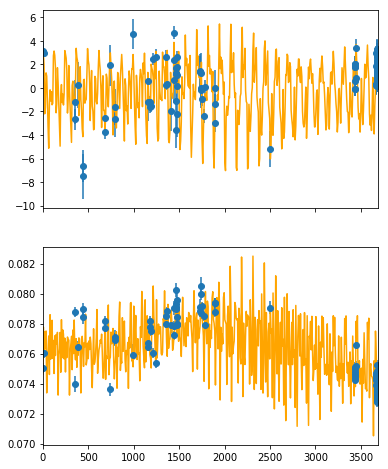

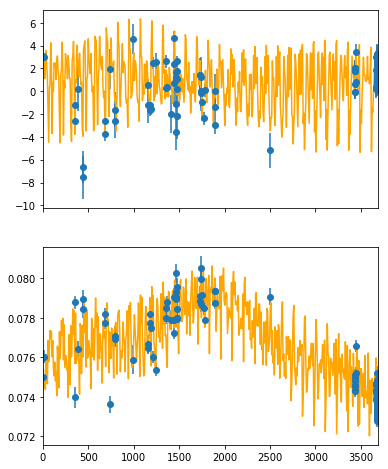

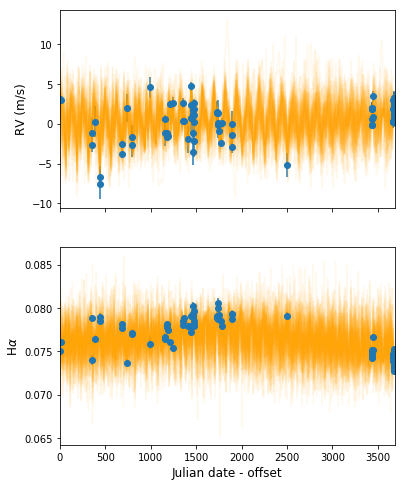

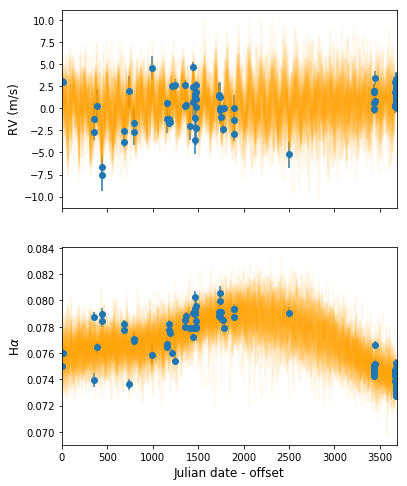

In [952]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
samples_lt = sampler_lt.chain[:, nburn_lt:, :].reshape((-1, ndim_lt))

# Plot 50 possible RV curves drawn from the flat chain, along with the data
fig01, (ax01, ax02) = plt.subplots(2, sharex=True, figsize=(6,8))
fig02, (ax03, ax04) = plt.subplots(2, sharex=True, figsize=(6,8))
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))
fig2, (ax3, ax4) = plt.subplots(2, sharex=True, figsize=(6,8))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
tt2 = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)

for i in range(nwalkers):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    n2 = np.random.randint(0, samples_lt.shape[0])
    spars_RV, spars_ha = split_par_vec(samples[n])
    spars_RV2, spars_ha_lt = split_par_vec_lt(samples_lt[n2])
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    gp_RV2.set_parameter_vector(spars_RV2)
    gp_ha_lt.set_parameter_vector(spars_ha_lt)
    if(i == 0):
        ax01.plot(tt, gp_RV.sample_conditional(allRV, tt), "orange")
        ax02.plot(tt, gp_ha.sample_conditional(allha, tt), "orange")
        ax03.plot(tt, gp_RV2.sample_conditional(allRV, tt2), "orange")
        ax04.plot(tt, gp_ha_lt.sample_conditional(allha, tt2), "orange")    
    # Plot a single sample.
    ax1.plot(tt, gp_RV.sample_conditional(allRV, tt), "orange", alpha=0.07)
    ax2.plot(tt, gp_ha.sample_conditional(allha, tt), "orange", alpha=0.07)
    ax3.plot(tt, gp_RV2.sample_conditional(allRV, tt2), "orange", alpha=0.07)
    ax4.plot(tt, gp_ha_lt.sample_conditional(allha, tt2), "orange", alpha=0.07)
# Plot the real data
ax01.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax02.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax03.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax04.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax02.set_xlim(alldates[0], alldates[-1])
ax04.set_xlim(alldates[0], alldates[-1])
ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax2.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax3.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax4.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax2.set_xlim(alldates[0], alldates[-1])
ax4.set_xlim(alldates[0], alldates[-1])
##ax2.set_ylim(0.06, 0.10)
##ax3.set_ylim(-15, 15)
ax2.set_xlabel("Julian date - offset", fontsize='large')
ax4.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("RV (m/s)", fontsize='large')
ax2.set_ylabel(r"H$\alpha$", fontsize='large')
ax3.set_ylabel("RV (m/s)", fontsize='large')
ax4.set_ylabel(r"H$\alpha$", fontsize='large')

# 6. Examine posteriors and covariances:

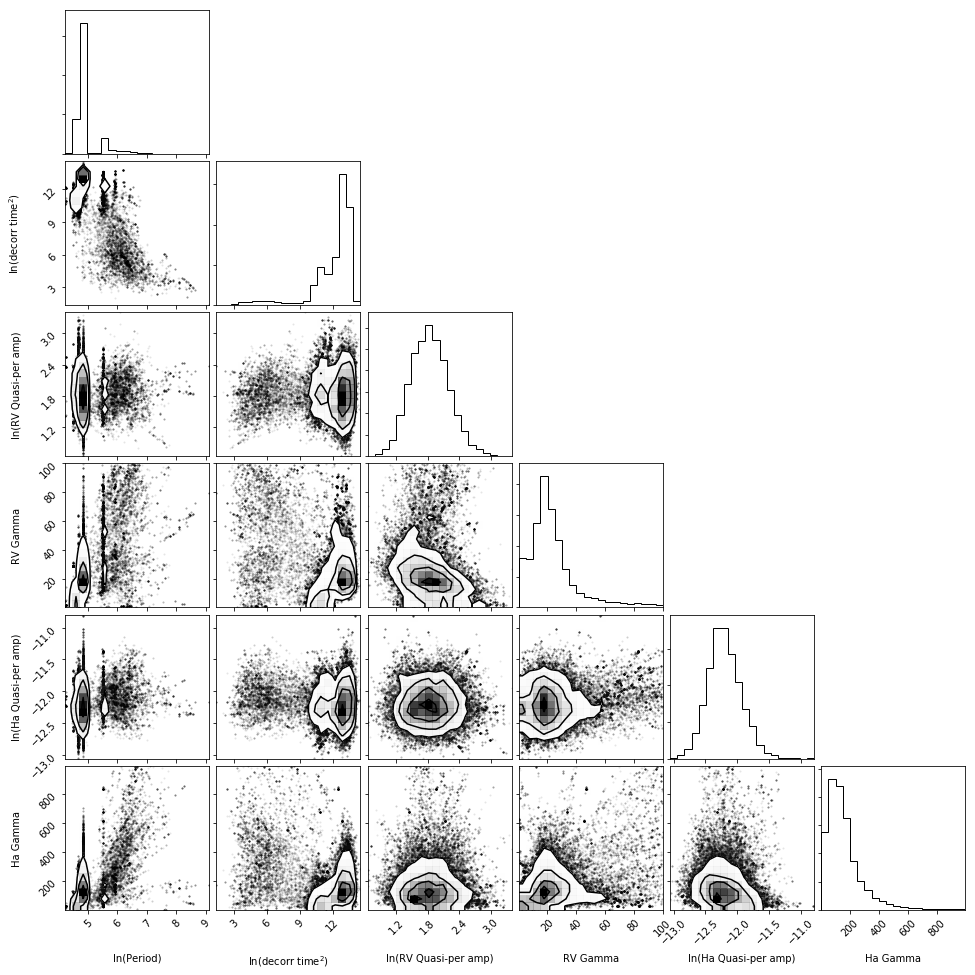

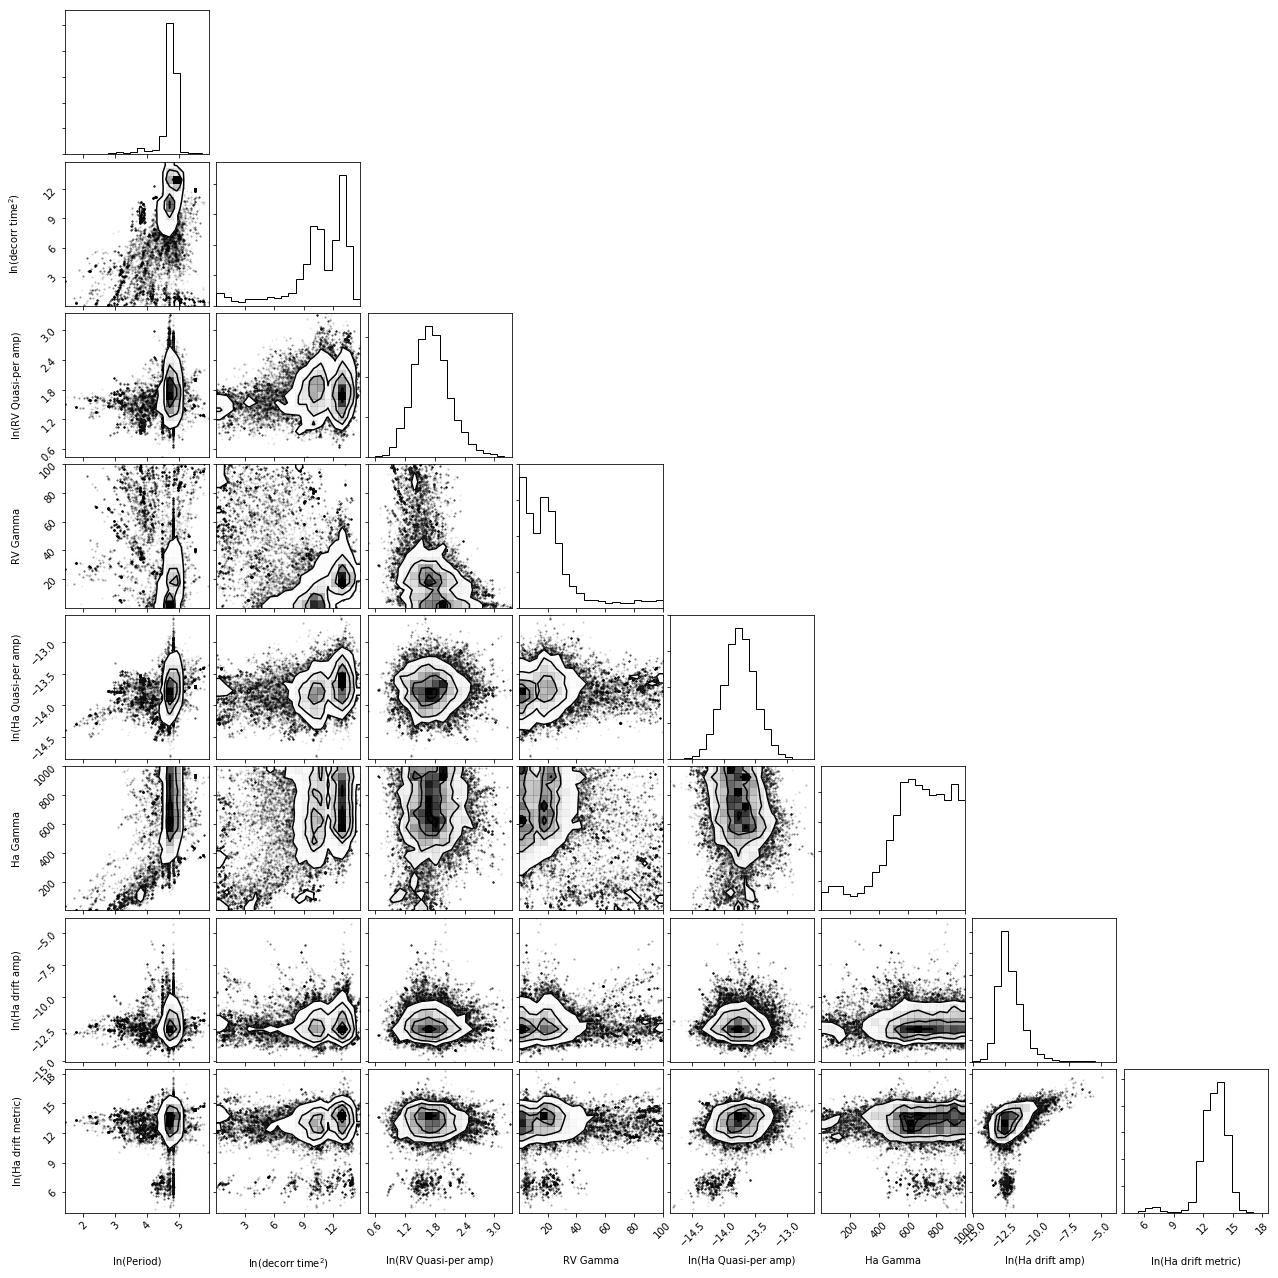

In [953]:
# import corner
parnamers = ["ln(Period)", "ln(decorr time$^2$)", "ln(RV Quasi-per amp)", \
            "RV Gamma", "ln(Ha Quasi-per amp)", "Ha Gamma"]
parnames_lt = ["ln(Period)", "ln(decorr time$^2$)", "ln(RV Quasi-per amp)", \
            "RV Gamma", "ln(Ha Quasi-per amp)", "Ha Gamma", "ln(Ha drift amp)", \
            "ln(Ha drift metric)"]
cfig = corner.corner(samples, labels=parnames)
cfig2 = corner.corner(samples_lt, labels = parnames_lt)

### 7. What are the period and decorrelation timescale?

For Quasi-periodic
Bin containing most probable period: 122.5 -- 131.5 days
Bin containing most probable decorrelation time: 641.2 -- 676.7 days
Bin containing 2nd most probable decorrelation time: 712.2 -- 747.7 days

Period: 16, 50, 84 percentiles = 110.85 124.70 127.12 days
Decorrelation time: 16, 50, 84 percentiles = 219.89 599.22 795.32 days


For long term drift in Ha
Bin containing most probable period: 124.3 -- 124.7 days
Bin containing most probable decorrelation time:  1.0 -- 42.9 days
Bin containing 2nd most probable decorrelation time: 126.8 -- 168.7 days

Period: 16, 50, 84 percentiles = 99.01 124.11 124.75 days
Decorrelation time: 16, 50, 84 percentiles = 73.40 253.76 725.36 days


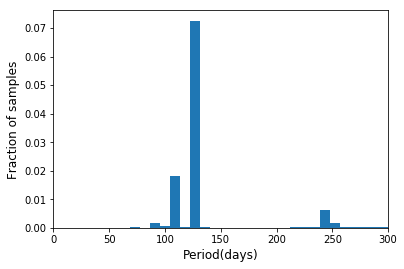

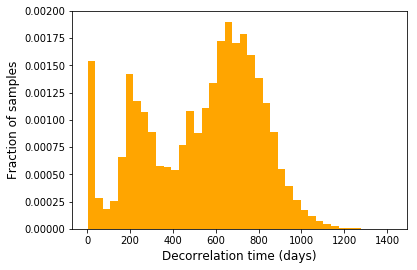

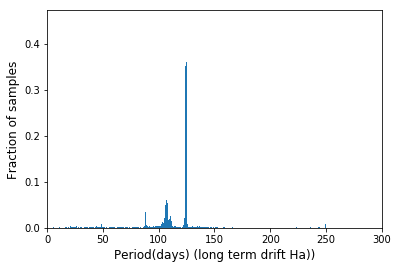

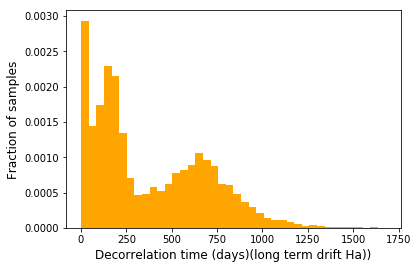

In [954]:
# Plots
plt.figure()
###Made a change here with adding 500. Sme below
periods = np.exp(samples[:,0])
dctimes = np.exp(0.5*samples[:,1])
n_per, bins_per, _ = plt.hist(periods, 1000, density=True)
plt.xlabel("Period(days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')
plt.xlim([0,300])
##plt.ylim([0,0.07])
plt.figure()
n_dc, bins_dc, _ = plt.hist(dctimes, 40, density=True, facecolor='orange')
plt.xlabel("Decorrelation time (days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')

plt.figure()
periods_lt = np.exp(samples_lt[:,0])
dctimes_lt = np.exp(0.5*samples_lt[:,1])
n_per_lt, bins_per_lt, _ = plt.hist(periods_lt, 1000, density=True)
plt.xlabel("Period(days) (long term drift Ha))", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')
plt.xlim([0,300])
##plt.ylim([0, 0.05])
plt.figure()
n_dc_lt, bins_dc_lt, _ = plt.hist(dctimes_lt, 40, density=True, facecolor='orange')
plt.xlabel("Decorrelation time (days)(long term drift Ha))", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')

# Numbers
per_bestbin = np.argmax(n_per)
dc_bestbin = np.argmax(n_dc)
dc_sort = np.argsort(n_dc)
print("For Quasi-periodic")
print("Bin containing most probable period: %4.1f -- %4.1f days" \
      % (bins_per[per_bestbin], bins_per[per_bestbin+1]))
print("Bin containing most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_bestbin], bins_dc[dc_bestbin+1]))
print("Bin containing 2nd most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_sort[-2]], bins_dc[dc_sort[-2]+1]))
pctiles = [16, 50, 84]
pervals = np.percentile(periods, pctiles)
dcvals = np.percentile(dctimes, pctiles)
print("\nPeriod: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (pervals[0], pervals[1], pervals[2]), "days")
print("Decorrelation time: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (dcvals[0], dcvals[1], dcvals[2]), "days")

print("\n")
print("For long term drift in Ha")
per_bestbin_lt = np.argmax(n_per_lt)
dc_bestbin_lt = np.argmax(n_dc_lt)
dc_sort_lt = np.argsort(n_dc_lt)
print("Bin containing most probable period: %4.1f -- %4.1f days" \
      % (bins_per_lt[per_bestbin_lt], bins_per_lt[per_bestbin_lt+1]))
print("Bin containing most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc_lt[dc_bestbin_lt], bins_dc_lt[dc_bestbin_lt+1]))
print("Bin containing 2nd most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc_lt[dc_sort_lt[-2]], bins_dc_lt[dc_sort_lt[-2]+1]))
pctiles_lt = [16, 50, 84]
pervals_lt = np.percentile(periods_lt, pctiles_lt)
dcvals_lt = np.percentile(dctimes_lt, pctiles_lt)
print("\nPeriod: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (pervals_lt[0], pervals_lt[1], pervals_lt[2]), "days")
print("Decorrelation time: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (dcvals_lt[0], dcvals_lt[1], dcvals_lt[2]), "days")

# Amusing myself with python's crazy way of interpreting lists and tuples
# Now I have a fun formatting example for future reference! (adapted from
# emcee tutorial)
##po, dco = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
 ##             zip(*np.percentile(np.column_stack((periods, dctimes)), \
##              pctiles, axis=0)))
##print("\nPeriod = %4.2f +%4.2f -%4.2f" % po, "days")
##print("Decorrelation time = %4.2f +%4.2f -%4.2f" % dco, "days")

## 8. What path through parameter space does each walker take?

Text(0.5,0,'Step number')

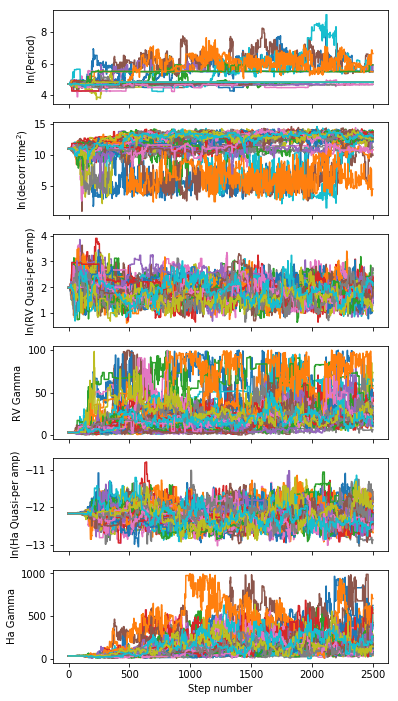

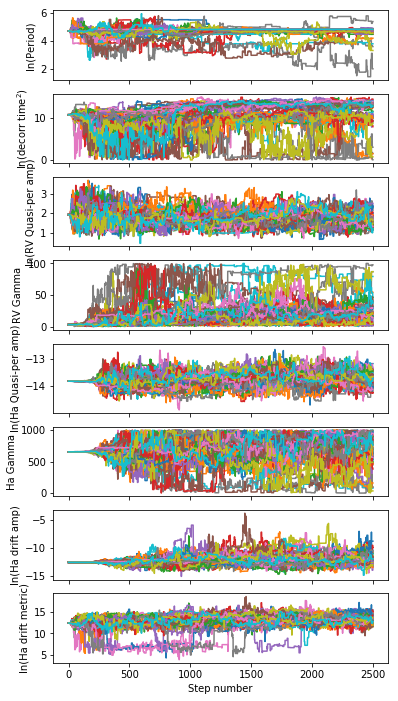

In [955]:
fig, axarr = plt.subplots(6, sharex=True, figsize=(6,12))
nsteps = nburn + nproduce
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[5].set_xlabel('Step number')

fig2, axarr_lt = plt.subplots(8, sharex=True, figsize = (6,12))
nsteps_lt = nburn_lt + nproduce_lt
step_lt = range(nsteps_lt)
for i in range(len(axarr_lt)):
    for w in range(nwalkers_lt):
        axarr_lt[i].plot(step_lt, sampler_lt.chain[w,:,i])
    axarr_lt[i].set_ylabel(parnames_lt[i])
axarr_lt[7].set_xlabel('Step number')

### 9. What is the BIC (Bayesian Information Criterion) distribution?

<par>$BIC = \ln(n) k - 2 \ln(\hat{L})$ where $n$ is the number of data points, $k$ is the number of free hyperparameters, and $\hat{L}$ is the likelihood of the observed dataset given the hyperparameters.</par>

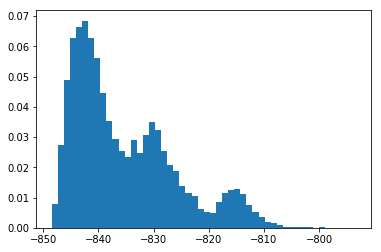

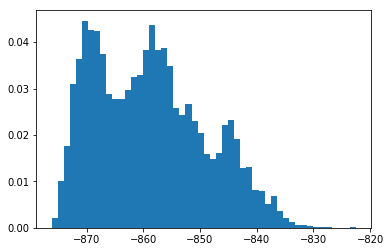

In [956]:
plt.figure()
nsamples = nwalkers * nproduce 
bics = np.zeros(nsamples)
for i in range(nsamples):
    bics[i] = np.log(npts) * npars + 2.*nll(samples[i,:])
n_bics, bins_bics, _ = plt.hist(bics, 50, density=True)

plt.figure()
nsamples_lt = nwalkers_lt * nproduce_lt
bics_lt = np.zeros(nsamples_lt)
for i in range(nsamples_lt):
    bics_lt[i] = np.log(npts) * npars_lt + 2.*nll_lt(samples_lt[i,:])
n_bics_lt, bins_bics_lt, _ = plt.hist(bics_lt, 50, density = True)

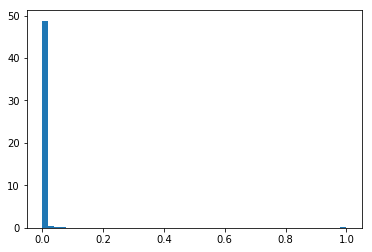

In [957]:
###Likelihood ratios

from scipy.stats.distributions import chi2
def likelihood_ratio(llmin, llmax):
    ##DEFAULT: llmax-llmin
    return(2*(llmax-llmin))

plt.figure()
likelihoods = np.zeros(nsamples)
for i in range(nsamples):
    LR = likelihood_ratio(-nll(samples[i,:]), -nll_lt(samples_lt[i,:]))
    likelihoods[i] = chi2.sf(LR,2)
n_likes, bins_likes, _ = plt.hist(likelihoods, 50, density=True)

# These models are still pretty rough! I am consulting with a "real" statistician about the proper likelihood function for the shared Gaussian process model. We have to think about whether the posteriors make sense.

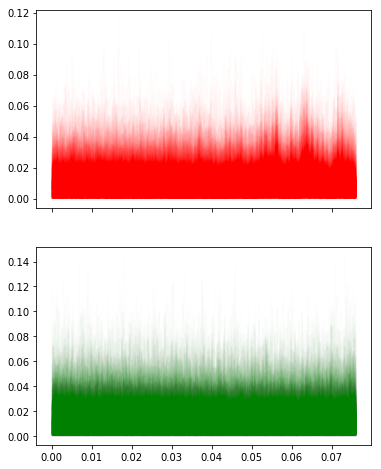

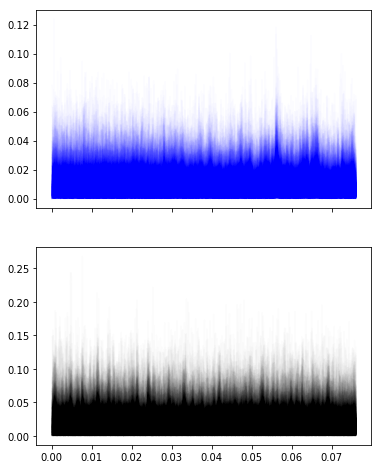

In [958]:
# ##Creating residual plots FIGURE THIS OUT!!
fig3, (ax5, ax6) = plt.subplots(2, sharex=True, figsize=(6,8))
fig4, (ax7,ax8) = plt.subplots(2, sharex=True, figsize=(6,8))
pdsRV = np.zeros(500)
pdsHa = np.zeros(500)
pdsRVlt = np.zeros(500)
pdsHalt = np.zeros(500)
for j in range(500):
    # Choose a sample
    m = np.random.randint(0, (samples.shape[0]))
    m_lt = np.random.randint(0, (samples_lt.shape[0]))
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    gp_RV2.set_parameter_vector(spars_RV2)
    gp_ha_lt.set_parameter_vector(spars_ha_lt)
    ##INSTEAD OF USING THIS, USE THE SPLIT PAR VEC FUNCTION, AND PLOT BOTH RESIDUALS AT THE SAME TIME
  ###  gp_RV.set_parameter_vector(samples[n][0:4])
    
    
    #get residuals

    ##gpRVsample = gp_RV.sample_conditional(rv,date)
    ##print(gpRVsample.size)
    
    residRV = allRV - gp_RV.sample_conditional(allRV, alldates) 
    residHa = allha - gp_ha.sample_conditional(allha, alldates)
    residRVlt = allRV - gp_RV2.sample_conditional(allRV, alldates)
    residHalt = allha - gp_ha_lt.sample_conditional(allha, alldates)
                
    #periodogram
    xiRV, pspecRV = LombScargle(alldates, residRV, allRVerr).autopower()
    xiha, pspecha = LombScargle(alldates, residHa, allhaerr).autopower()
    xiRVlt, pspecRVlt = LombScargle(alldates, residRVlt, allRVerr).autopower()
    xihalt, pspechalt = LombScargle(alldates, residHalt, allhaerr).autopower()
    
    subRV = np.argmax(pspecRV)
    pdsRV[j] = 1.0/xiRV[subRV]
    subHa = np.argmax(pspecha)
    pdsHa[j] = 1.0/xiha[subHa]
    subRVlt = np.argmax(pspecRVlt)
    pdsRVlt[j] = 1.0/xiRVlt[subRVlt]
    subHalt = np.argmax(pspechalt)
    pdsHalt[j] = 1.0/xihalt[subHalt]
    
    ax5.plot(xiRV, pspecRV, 'r-', alpha=0.01)
    ax6.plot(xiha, pspecha, 'g-', alpha=0.01)
    ax7.plot(xiRVlt, pspecRVlt, 'b-', alpha=0.01)
    ax8.plot(xihalt, pspechalt, 'k-', alpha=0.01)



##ax3.set_xlim(alldates[-1], alldates[111])
##ax4.set_xlim(alldates[-1], alldates[111])

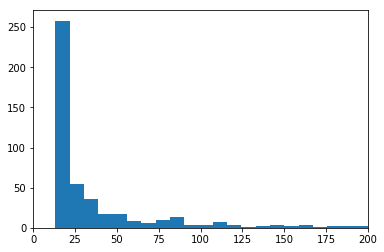

RV residual:  ModeResult(mode=array([15.64834603]), count=array([9]))


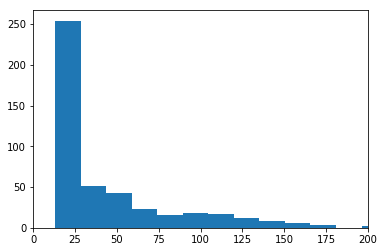

Ha residual:  ModeResult(mode=array([13.19260416]), count=array([4]))


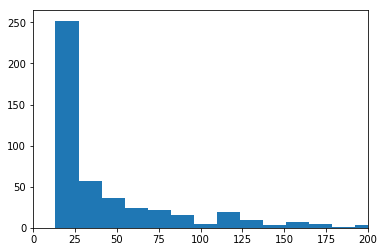

RV residual lt:  ModeResult(mode=array([17.79630652]), count=array([13]))


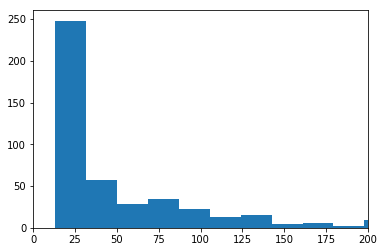

Ha residual lt:  ModeResult(mode=array([85.82880699]), count=array([5]))


In [959]:
from scipy import stats

plt.hist(pdsRV, bins='auto')
plt.xlim(0,200)
plt.show()
plt.close()
print("RV residual: ", stats.mode(pdsRV))
plt.hist(pdsHa, bins='auto')
plt.xlim(0,200)
plt.show()
plt.close()
print("Ha residual: ", stats.mode(pdsHa))
plt.hist(pdsRVlt, bins='auto')
plt.xlim(0,200)
plt.show()
plt.close()
print("RV residual lt: ", stats.mode(pdsRVlt))
plt.hist(pdsHalt, bins='auto')
plt.xlim(0,200)
plt.show()
plt.close()
print("Ha residual lt: ", stats.mode(pdsHalt))

# 

-github repo
- check single realization of GP before doing MCMC -- does it hit the error bars
 - lengthen sampler chains, longer burn in
 - check covariences in complex models
 
 - likelihood ratio & BIC histograms

## np.exp(16)


- ***go back to original notebook with rv only plot 1 sample at a time, does it hit data points?
- For Ha and RV do exp^2 kernel 2 parameters only, metric and amplitude. Do we converge? are posteriors well behaved? How well do we reproduce long term trend?
- can we force george to do a tighter fit?
- Check how to analyze behavior of diffrent sub-kernels
- Experiment with minimizer
- red noise tutorial--> systematic error
- mess around with white noise. try single value for niose
- augmenting error bars(add epsilon to error bars. Look at emcee and george tutorials
-github repo*
-Check sum of squared residuals for different models